<a href="https://colab.research.google.com/github/omkarwazulkar/TimeSeriesForecasting/blob/main/Champagne_Sales_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Describing** **the** **Dataset**

In [1]:
path = '/content/drive/MyDrive/Dataset/Datasets/champagne.csv'

In [2]:
from pandas import read_csv
series = read_csv(path, header=0, index_col=0, parse_dates=True, squeeze=True)

In [3]:
print(series)

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Sales, Length: 105, dtype: int64


In [4]:
# Creating Train and Validation Dataset and Saving

split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 93, Validation 12


# **Testing Harness and Performance of Baseline Model**

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt

series = read_csv('/content/dataset.csv', header = None, index_col = 0, parse_dates = True, squeeze = True)
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.5)
train, test = X[0: train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  yhat = history[-1]
  predictions.append(yhat)
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print("RMSE : %.3f " % rmse)

>Predicted=5428.000, Expected=8314
>Predicted=8314.000, Expected=10651
>Predicted=10651.000, Expected=3633
>Predicted=3633.000, Expected=4292
>Predicted=4292.000, Expected=4154
>Predicted=4154.000, Expected=4121
>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2

In [8]:
series.describe()

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: 1, dtype: float64

# **Visualizing Data**

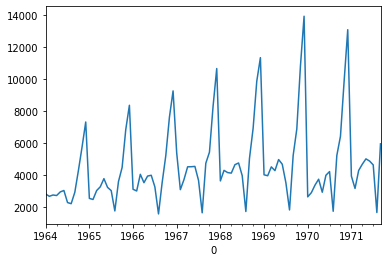

In [9]:
# Line Plot
from matplotlib import pyplot 

series.plot()
pyplot.show()

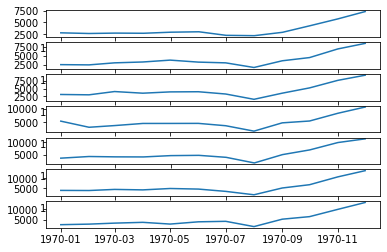

In [10]:
# Seasonal Line Plot

from pandas import DataFrame
from pandas import Grouper

groups = series['1964':'1970'].groupby(Grouper(freq = 'A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
  pyplot.subplot((n_groups * 100) + 10 + i)
  i += 1
  pyplot.plot(group)
pyplot.show()

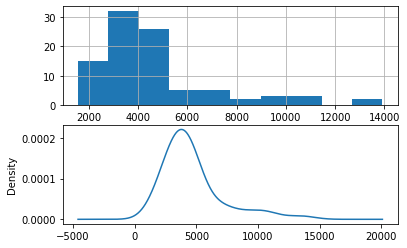

In [11]:
# Density Plot

pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind = 'kde')
pyplot.show()

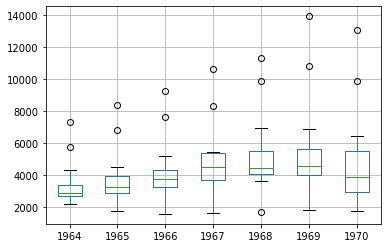

In [12]:
# Box and Whisker Plot
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()
pyplot.show()

# **Manually Configuring ARIMA**

In [14]:
# Creating a Differenced Function

def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)

In [15]:
# Inverting Differenced Values

def inverse_difference(history, yhat, interval = 1):
  return yhat + history[-interval]

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


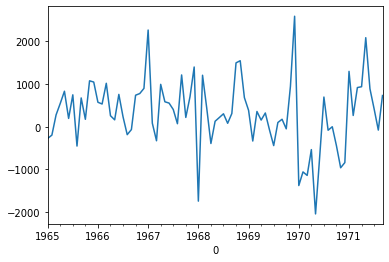

In [16]:
# Configuring the ARIMA manually
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
result = adfuller(stationary)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
stationary.to_csv('stationary.csv', header=False)
stationary.plot()
pyplot.show()

# **ACF and PACF for Manually Configured ARIMA**

0
1965-01-01    -274.0
1965-02-01    -197.0
1965-03-01     276.0
1965-04-01     545.0
1965-05-01     830.0
               ...  
1971-05-01    2083.0
1971-06-01     888.0
1971-07-01     416.0
1971-08-01     -79.0
1971-09-01     730.0
Name: 1, Length: 81, dtype: float64


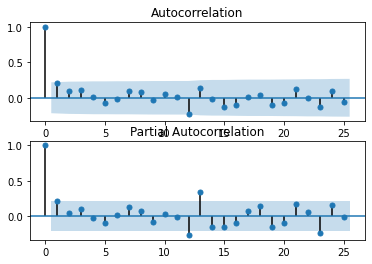

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series = read_csv('/content/stationary.csv', header = None, index_col = 0, parse_dates = True, squeeze = True)
print(series)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=25, ax = pyplot.gca())
pyplot.subplot(212)     
plot_pacf(series, lags=25, ax = pyplot.gca())
pyplot.show()

# **Evaluating Manually Configured ARIMA**

In [18]:
from statsmodels.tsa.arima_model import ARIMA

series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
  months_in_year = 12
  diff = difference(history, months_in_year)
  model = ARIMA(diff, order = (1,1,1))
  model_fit = model.fit(trend = 'nc', disp = 0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
  
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8089.892, Expected=8314.000
>Predicted=9742.786, Expected=10651.000
>Predicted=5986.916, Expected=3633.000
>Predicted=3886.954, Expected=4292.000
>Predicted=4038.120, Expected=4154.000
>Predicted=4992.340, Expected=4121.000
>Predicted=5156.385, Expected=4647.000
>Predicted=5046.669, Expected=4753.000
>Predicted=4143.877, Expected=3965.000
>Predicted=2102.942, Expected=1723.000
>Predicted=5228.292, Expected=5048.000
>Predicted=5873.444, Expected=6922.000
>Predicted=8571.264, Expected=9858.000
>Predicted=11006.038, Expected=11331.000
>Predicted=4087.455, Expected=4016.000
>Predicted=4771.842, Expected=3957.000
>Predicted=4676.086, Expected=4510.000
>Predicted=4583.396, Expected=4276.000
>Predicted=5117.345, Expected=4968.000
>Predicted=5208.150, Expected=4677.000
>Predicted=4436.445, Expected=3523.000
>Predicted=2180.952, Expected=1821.000
>Predicted=5471.264, Expected=5222.000
>Predicted=7337.610, Expected=6872.000
>Predicted=10268.369, Expected=10803.000
>Predicted=11725.422

# **Automatically Configured ARIMA using GRID Search HyperParmeters**

In [19]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

In [20]:
# Creating a Differenced Function

def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return numpy.array(diff)

In [21]:
# Inverting Differenced Values

def inverse_difference(history, yhat, interval = 1):
  return yhat + history[-interval]

In [22]:
# Evaluate ARIMA Model

def evaluate_arima_model(X, arima_order):
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    months_in_year = 12
    diff = difference(history, months_in_year)
    model = ARIMA(diff, order = arima_order)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    history.append(test[t])
    # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

In [23]:
# Finding Best Set of p,d, q Values

def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [24]:
series = read_csv('/content/dataset.csv', header = None, index_col = 0, parse_dates = True, squeeze = True)
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.794
ARIMA(0, 0, 5) RMSE=986.836
ARIMA(0, 0, 6) RMSE=1087.012
ARIMA(0, 1, 1) RMSE=958.297
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.960
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 0, 1) RMSE=948.619
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.921
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.654
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.940
ARIMA(3, 2, 0) RMSE=1244.847
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.258
ARIMA(4, 2, 0) RMSE=1227.556
ARIMA(4, 2, 1) RMSE=1055.487
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 1, 1) RMSE=1023.405
ARIMA(5, 1, 2) RMSE=1003.157
ARIMA(5, 2, 1) RMSE=1053.728
ARIMA(6, 0, 0) RMSE=996.466
ARIMA(6, 0, 2) RMSE=922.105
ARIMA(6, 1, 0) RMSE=1018.211
AR

In [25]:
# Finalising ARIMA Paramaters as (6, 0, 2)

# **Summarizing ARIMA Model Residuals using our fixed parameters as (6, 0, 2)**

In [26]:
# Finding Diff
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

In [27]:
# Inverted Diff
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

In [28]:
# Summarizing ARIMA Model Residuals
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
  months_in_year = 12
  diff = difference(history, months_in_year)
  model = ARIMA(diff, order=(6,0,2))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  obs = test[i]
  history.append(obs)

In [29]:
# Reviewing Residual Errors  
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

                 0
count    47.000000
mean     92.395663
std     927.383040
min   -2106.541558
25%    -468.105378
50%     139.128371
75%     569.611284
max    2344.852096


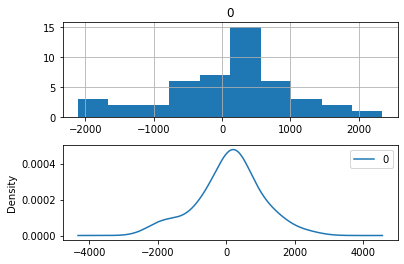

In [30]:
# Plotting Histogram and Density Graph to evaluate Distribution
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

# **Adding Bias to Reduce Residual Errors**

In [31]:
# Summarizing ARIMA Model Residuals
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
bias = 92.395663
for i in range(len(test)):
  months_in_year = 12
  diff = difference(history, months_in_year)
  model = ARIMA(diff, order=(6,0,2))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  obs = test[i]
  history.append(obs)

                  0
count  4.700000e+01
mean   4.553083e-08
std    9.273830e+02
min   -2.198937e+03
25%   -5.605010e+02
50%    4.673271e+01
75%    4.772156e+02
max    2.252456e+03


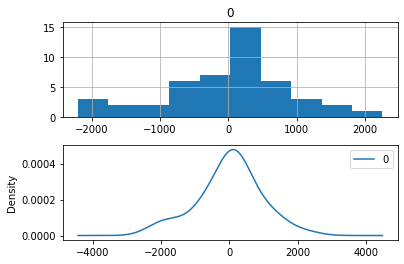

In [32]:
# Reviewing Residual Errors  
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# Plotting Histogram and Density Graph to evaluate Distribution
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

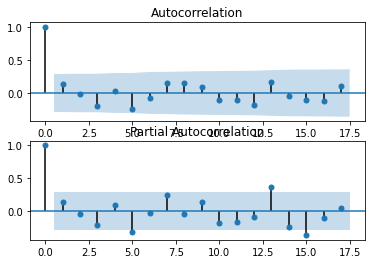

In [33]:
# Plotting ACF and PACF Plots
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [34]:
# Saving the Model with Final Parameters
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

# Patching Bug in ARIMA Case
def __getnewargs__(self):
  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# Differenced Series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# Data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# Enhancing Data
X = series.values
X = X.astype('float32')

months_in_year = 12
diff = difference(X, months_in_year)

# Fitting Model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)

# Bias observed from Mean
bias = 92.395663

# Saving Model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [35]:
# Loading Model and Making Prediction
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# Inverting Differenced Values
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# Data Load
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12

# Model Load
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')

# Making Predication
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6721.264


>Predicted=6721.264, Expected=6981.000
>Predicted=10082.369, Expected=9851.000
>Predicted=13370.789, Expected=12670.000
>Predicted=3934.135, Expected=4348.000
>Predicted=3474.435, Expected=3564.000
>Predicted=4360.575, Expected=4577.000
>Predicted=5008.304, Expected=4788.000
>Predicted=5105.588, Expected=4618.000
>Predicted=5036.136, Expected=5312.000
>Predicted=4758.625, Expected=4298.000
>Predicted=1721.189, Expected=1413.000
>Predicted=5933.520, Expected=5877.000
RMSE: 354.844


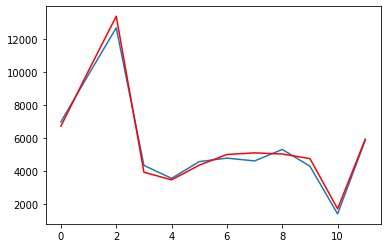

In [36]:
# Validating Model

# Load and Preparing Datasets
dataset = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12

# Validation Dataset
validation = read_csv('/content/validation.csv', header=None, index_col=0, parse_dates=True,squeeze=True)
y = validation.values.astype('float32')

# Loading Model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')

# Predicting
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# Forecasts
for i in range(1, len(y)):
  months_in_year = 12
  diff = difference(history, months_in_year)
  model = ARIMA(diff, order=(6, 0, 2))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# Performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()